# Models for Win / Loose determination based on one player's data

## Import MatPlotLib & Setup

In [17]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [18]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

## Import Data

In [19]:
df_game_events = pd.read_csv("../data/game_events.csv")
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killer_name', 'killer_team_id',]

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
game_metadata_features = ['game_id']

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
df_game_players_stats.head()

game_players_stats_features_num = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

game_players_stats_features_by_user_num = ['player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 
                                            'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                                            'largest_killing_spree', 'largest_multi_kill']
game_players_stats_features_by_user_cat = ['champion_name']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
match_players = df_game_players_stats[df_game_players_stats['game_id'] == 0]
match_players.head(10)

,game_id,player_id,player_name,team_id,team_name,team_acronym,role,win,game_length,champion_name,team_kills,tower_kills,inhibitor_kills,dragon_kills,herald_kills,baron_kills,player_kills,player_deaths,player_assists,total_minions_killed,gold_earned,level,total_damage_dealt,total_damage_dealt_to_champions,total_damage_taken,wards_placed,largest_killing_spree,largest_multi_kill
30,0,21,Stark,4,Team Flash,TF,Top,True,2010,Renekton,22,10,1,2,1,2,4,4,9,275,14760,17,187887,12604,31066,18,2,1
31,0,22,Venus,5,Lowkey Esport Vietnam,LK,Support,False,2010,Nautilus,18,2,0,0,0,0,2,5,10,61,8188,13,23397,5298,12630,47,2,1
32,0,23,YiJin,4,Team Flash,TF,Jungle,True,2010,Sejuani,22,10,1,2,1,2,4,2,13,157,12963,16,165390,9776,38185,11,3,2
33,0,24,Celebrity,5,Lowkey Esport Vietnam,LK,Bot,False,2010,Ezreal,18,2,0,0,0,0,2,4,10,285,13108,16,197852,24770,13523,12,2,1
34,0,25,DNK,5,Lowkey Esport Vietnam,LK,Jungle,False,2010,Sylas,18,2,0,0,0,0,8,3,8,186,13850,16,169050,17982,27204,13,5,1
35,0,26,Artifact,5,Lowkey Esport Vietnam,LK,Mid,False,2010,Jayce,18,2,0,0,0,0,5,5,6,280,12926,17,171573,19579,15644,18,3,2
36,0,27,Hinn,4,Team Flash,TF,Support,True,2010,Morgana,22,10,1,2,1,2,1,4,16,15,8960,13,13032,4666,11567,59,0,1
37,0,28,Artemis,4,Team Flash,TF,Bot,True,2010,Lucian,22,10,1,2,1,2,9,6,7,289,15487,16,223488,20707,23348,11,4,2
38,0,29,Hani,5,Lowkey Esport Vietnam,LK,Top,False,2010,Kennen,18,2,0,0,0,0,1,5,5,229,11160,16,136281,10920,16643,13,0,1
39,0,30,C7N,4,Team Flash,TF,Mid,True,2010,Karma,22,10,1,2,1,2,4,2,11,303,15143,18,196700,14106,12036,15,2,2


## Preprocessing data for win determination with one player's data

In [20]:
def get_useful_players_data(dataframe : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    new_df['KLA'] = (dataframe['player_kills'] + dataframe['player_assists']) / (dataframe['player_deaths'] + 1)
    new_df['gold_pm'] = dataframe['gold_earned'] / dataframe['game_length']
    new_df['lvl_pm'] = dataframe['level'] / dataframe['game_length']
    new_df['creep_score_pm'] = dataframe['total_minions_killed'] / dataframe['game_length']
    new_df['wards_pm'] = dataframe['wards_placed'] / dataframe['game_length']
    
    new_df['damage_pm'] = dataframe['total_damage_dealt'] / dataframe['game_length']
    new_df['damage_to_champions_pm'] = dataframe['total_damage_dealt_to_champions'] / dataframe['game_length']
    new_df['damage_taken_pm'] = dataframe['total_damage_taken'] / dataframe['game_length']
    
    new_df['greatest_killing_spree'] = dataframe['largest_killing_spree']
    new_df['greatest_multi_kill'] = dataframe['largest_multi_kill']
    
    return new_df

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_stats[df_game_players_stats['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

win_loose_preprocessor = make_column_transformer((StandardScaler(), useful_player_columns_num))

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']


def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
    X = df_game_players_stats.loc[df_game_players_stats['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, y_train, y_test = group_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    
    return X_train, X_valid, y_train, y_test

## Create the model

In [21]:
def get_model(input_shape: int) -> keras.Model:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_shape]),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')   
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return model

def train_model(X_train, X_valid, y_train, y_valid, model, epochs=10, batch_size=128):
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )
    
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=epochs, 
        batch_size=batch_size, 
        callbacks=[early_stopping],
        verbose=0
    )
    
    return history

## Data fetching for Top role

In [22]:
top_X_train, top_X_valid, top_y_train, top_y_valid = get_role_data(player_roles[0], 0)

jungle_input_shape = [top_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

# print("First 5 elements of X:")
# print(X[:5])
# print("\nFirst 5 elements of y:")
# print(y[:5])

Input shape: [10]


## 'Top' Model training 

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

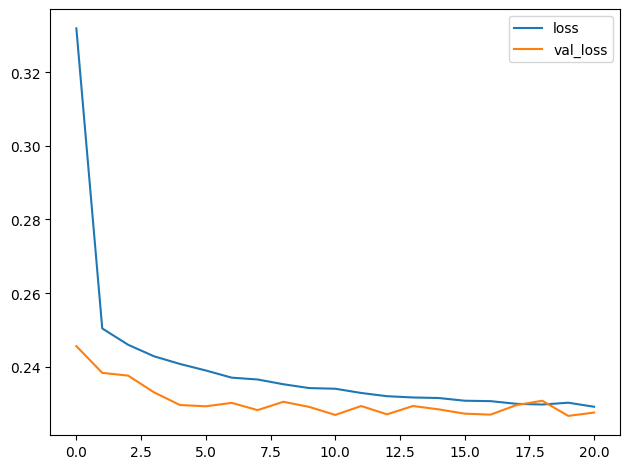

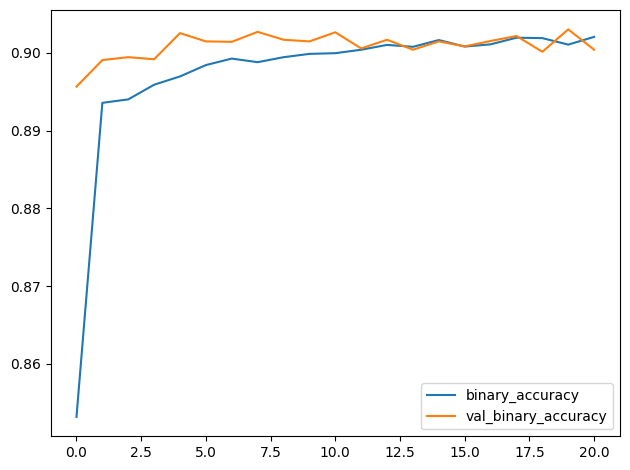

In [23]:
top_model = get_model(jungle_input_shape[0])

top_history = train_model(
    top_X_train, top_X_valid, top_y_train, top_y_valid, top_model, 
    epochs=100, batch_size=256)

top_history_df = pd.DataFrame(top_history.history)

# Plot the training and validation loss
top_history_df.loc[0:, ['loss', 'val_loss']].plot()
top_history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()


## Test 'Top' model

In [24]:
# Test with the player id 21:
top_X_test_1 = get_solo_player_data(21, 0)
top_X_test_2 = get_solo_player_data(29, 0)
    
top_X_test_1_preprocessed = win_loose_preprocessor.transform(top_X_test_1)
top_X_test_2_preprocessed = win_loose_preprocessor.transform(top_X_test_2)

# Make predictions
top_prediction_1 = top_model.predict(top_X_test_1_preprocessed)
top_prediction_2 = top_model.predict(top_X_test_2_preprocessed)

# For a binary classification, you may want to interpret the outputs
top_predicted_win_1 = top_prediction_1[0][0] > 0.5
top_predicted_win_2 = top_prediction_2[0][0] > 0.5
print(f"Predicted outcome for player 21: {'Win' if top_predicted_win_1 else 'Loss'}")
print(f"Predicted outcome for player 29: {'Win' if top_predicted_win_2 else 'Loss'}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted outcome for player 21: Win
Predicted outcome for player 29: Loss


## Data fetching for 'Jungle' role

In [25]:
jungle_X_train, jungle_X_valid, jungle_y_train, jungle_y_valid = get_role_data(player_roles[1])

jungle_input_shape = [jungle_X_train.shape[1]]
print("Input shape: {}".format(jungle_input_shape))

Input shape: [10]


## 'Jungle' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

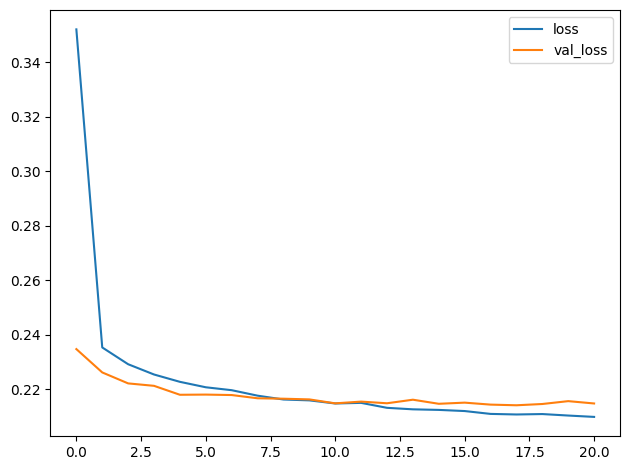

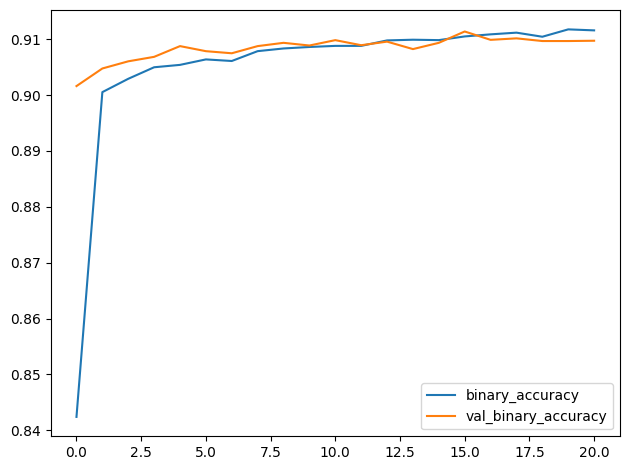

In [26]:
jungle_model = get_model(jungle_input_shape[0])

jungle_history = train_model(
    jungle_X_train, jungle_X_valid, jungle_y_train, jungle_y_valid, jungle_model, 
    epochs=100, batch_size=256)

jungle_history_df = pd.DataFrame(jungle_history.history)

# Plot the training and validation loss
jungle_history_df.loc[0:, ['loss', 'val_loss']].plot()
jungle_history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Data fetching for 'Middle' role

In [27]:
mid_X_train, mid_X_valid, mid_y_train, mid_y_valid = get_role_data(player_roles[2])

mid_input_shape = [mid_X_train.shape[1]]
print("Input shape: {}".format(mid_input_shape))

Input shape: [10]


## 'Middle' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

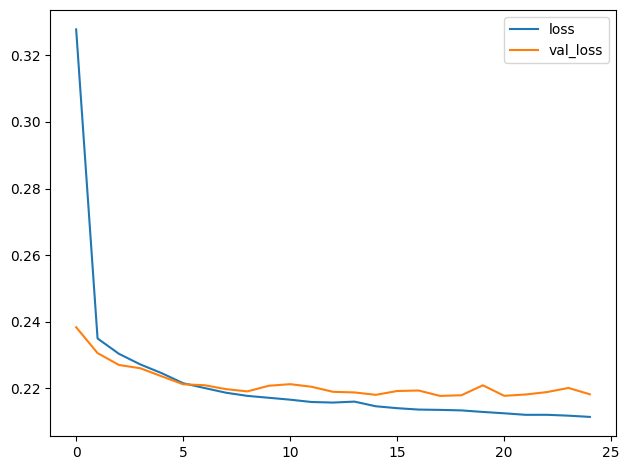

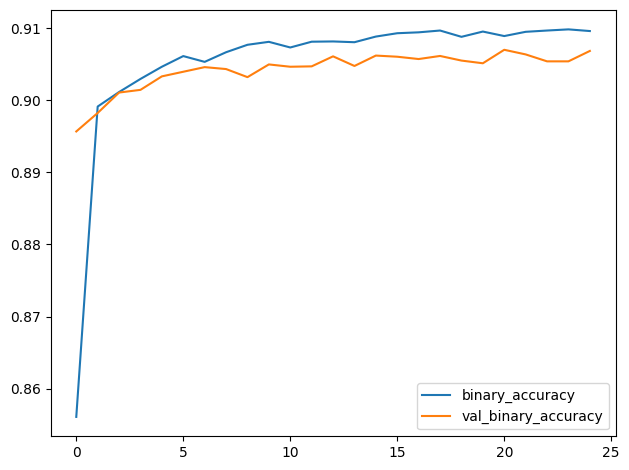

In [28]:
mid_model = get_model(mid_input_shape[0])

mid_history = train_model(
    mid_X_train, mid_X_valid, mid_y_train, mid_y_valid, mid_model, 
    epochs=100, batch_size=256)

mid_history_df = pd.DataFrame(mid_history.history)

# Plot the training and validation loss
mid_history_df.loc[0:, ['loss', 'val_loss']].plot()
mid_history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Data fetching for 'Support' role

In [29]:
sup_X_train, sup_X_valid, sup_y_train, sup_y_valid = get_role_data(player_roles[2])

sup_input_shape = [sup_X_train.shape[1]]
print("Input shape: {}".format(sup_input_shape))

Input shape: [10]


## 'Support' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

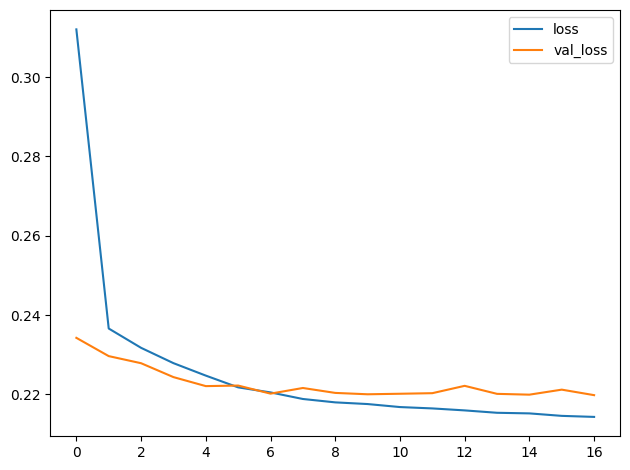

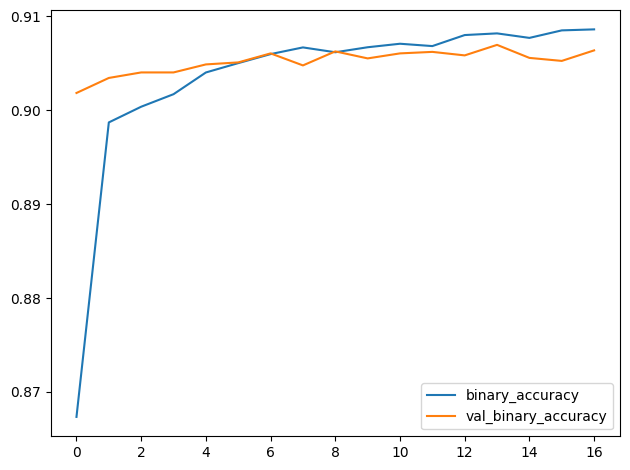

In [30]:
sup_model = get_model(sup_input_shape[0])

sup_history = train_model(
    sup_X_train, sup_X_valid, sup_y_train, sup_y_valid, sup_model, 
    epochs=100, batch_size=256)

sup_history_df = pd.DataFrame(sup_history.history)

# Plot the training and validation loss
sup_history_df.loc[0:, ['loss', 'val_loss']].plot()
sup_history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Data fetching for 'Bottom' role

In [31]:
bot_X_train, bot_X_valid, bot_y_train, bot_y_valid = get_role_data(player_roles[4])

bot_input_shape = [bot_X_train.shape[1]]
print("Input shape: {}".format(bot_input_shape))

Input shape: [10]


## 'Bottom' model training

c:\Users\arthu\source\AI_LAB_MA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

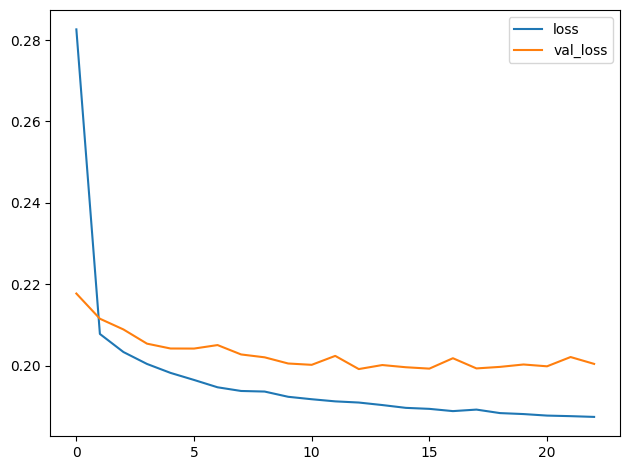

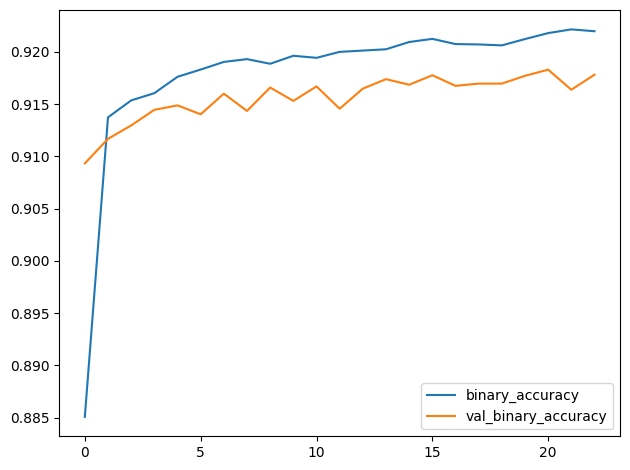

In [32]:
bot_model = get_model(bot_input_shape[0])

bot_history = train_model(
    bot_X_train, bot_X_valid, bot_y_train, bot_y_valid, bot_model, 
    epochs=100, batch_size=256)

bot_history_df = pd.DataFrame(bot_history.history)

# Plot the training and validation loss
bot_history_df.loc[0:, ['loss', 'val_loss']].plot()
bot_history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Save models

In [ ]:
import os
import joblib
    
def save_all_models():
    os.makedirs('role_models', exist_ok=True)
    
    top_model.save('role_models/top_model.keras')
    jungle_model.save('role_models/jungle_model.keras')
    mid_model.save('role_models/mid_model.keras')
    sup_model.save('role_models/sup_model.keras')
    bot_model.save('role_models/bot_model.keras')
    
def save_tools():
    os.makedirs('tools', exist_ok=True)
    
    joblib.dump(win_loose_preprocessor, 'tools/win_loose_preprocessor.pkl')
    
save_all_models()
save_tools()